## Data Simulation

In this notebook, we provide scripts to generate both simple one-member population growth curves and more complex small-community growth curves. 

We begin by importing the necessary scientific and numerical python libraries. 

In [48]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

# Utility to help with for loop run time visualization
from tqdm.notebook import trange

### One Member Population Curves

We generate simple one-member population curves using the standard non-dimensionalized logistic growth curve:

$$
\dfrac{dp}{dt} = \mu \, p \, \left( 1 - p \right)
$$

We generate a dataset of 1000 individual growth curves by drawing the growth rate parameter $\mu$ from a Normal distribution $\mu \sim \mathcal{N}( 0.13, 0.02)$. We choose these values arbitrarily, and they can be readily adjusted in the code below to user specification. 

In [286]:
mean = 0.13
std = 0.02

#### Defining the ODE Model 

Now we define our ODE model and numerical simulation parameters. 

In [287]:
def logistic(p, t, mu):
    dpdt = mu*p*(1-p)
    return dpdt

In [288]:
# Define our time range of numerical integration scheme
time_range = np.linspace(0, 100, 101)

# Define initial condition
p_0 = 0.15

Now we will simulate 1,000 communites using random parameter values. 

In [289]:
# Number of individual communities to simulate
n = 1000

sols = []
for i in trange(n):
    mu = std*np.random.randn(1)+mean
    sol = odeint(logistic, p_0, time_range, args = (mu,)).squeeze()
    
    # Take the finite difference of the data
    sol = np.diff(sol)
    sols.append(sol)
    
# Print the shape of the final matrix
sols = np.array(sols)
sols.shape

  0%|          | 0/1000 [00:00<?, ?it/s]

(1000, 100)

Visualize the first 100 trajectories to visualize the simulation results.  

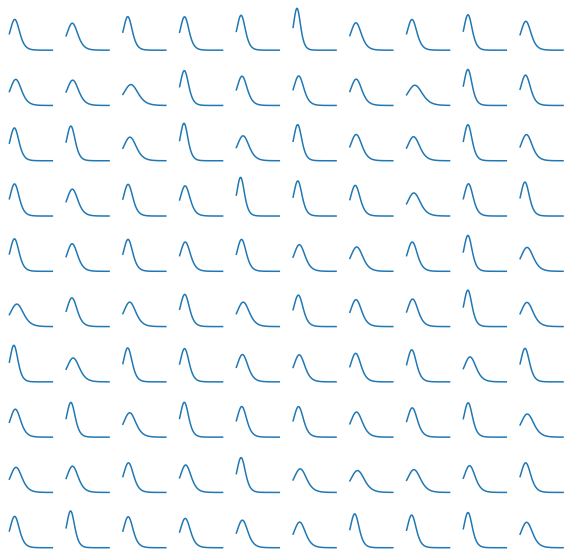

In [290]:
# Generate subplots
fig, axs = plt.subplots(10,10, figsize = (10,10), sharex = True, sharey = True)
axs = axs.flatten()

for i in range(100):
    axs[i].plot(sols[i])
    axs[i].axis("off")
plt.show()

Now we save the simulation as an example. 

In [291]:
np.savetxt("./saved_sims/ex_simple.csv", sols, delimiter=",")

### Small Community Simulation

In order to generate more complex growth curves beyond  simple logistic growth , we simulate multiple five member communities incorporating interactions between members. We then collect all of the growth curves into one final dataset, independent from which simulation they originated from. We model our communities using a version of generalized Lotka Volterra, where mutualistic interactions are saturating as to not allow unbounded growth:

$$
\dfrac{dp_i}{dt} = \mu_i\,p_i\,\left(1-p_i-\dfrac{\sigma}{1+\sum \gamma_{ij}^+ p_j} + \sum \gamma_{ij}^-p_j\right)
$$

We write down our model below:


In [93]:
def multi_species_model(p,t,  n , Gamma, sigma, mu):
    """
    Simulate a multispecies model of community growth. 
    
    Parameters
    ----------
    n: int
        The number of species to simulate
    
    Gamma: n x n np.array
        A matrix of the interaction terms where the ij-th term models the interaction
        strength of the ij-th species
    
    Sigma: n np.array
        A vector of the intrinsic external growth effect, generally set to a constant
    
    mu: n np.array
        A vector of the intrinsic growth rates of the bacteria
        
    p: n np.array
        A vector of the initial species distribution.
    """
    
    # We must construct a list of n elements, each corresponding to the growth derivative of each species
    dpdt = np.zeros(n)
    
    # Pull off all positive interactions and negative interactions
    Gamma_pos = Gamma*(Gamma > 0)
    Gamma_neg = Gamma*(Gamma < 0)
    
    # Compute the current value of the net positive and negative interaction terms
    gamma_pos = Gamma_pos @ p
    gamma_neg = Gamma_neg @ p
    
    # Compute the derivative term in vectorized form
    dpdt = mu * p * ( np.ones(n) - p - sigma/(np.ones(n)+gamma_pos)  + gamma_neg )
    
    return dpdt

We will also define a function to generate a set of random parameters for each of the communities. We draw the interaction matrix $\gamma$ and growth rates $\mu$ at random while holding the background stress term $\sigma$ fixed across simulations. We also will perform integration over the time interval $[0,2000]$, sampling every $15$ time points.  By default, we set $\sigma = 0.05$ and set the initial conditions to $\boldsymbol{p}(0) = 0.05$ for species. 

In [260]:
def random_parameters(n, int_mean, int_width, growth_mean, growth_var):
    
    # Generate simulation parameters
    time_range = np.linspace(0,2000,134)
    Gamma = int_width*np.random.randn(n,n) + int_mean*np.ones((n,n))
    sigma = 0.05*np.ones(n)
    mu = growth_mean*np.ones(n) + growth_var*np.random.randn(n)
    p_0 = 0.05*np.ones(n)
    
    return time_range, Gamma, sigma, mu, p_0

We now arbitrarily set the parameters for mean and standard deviation of the interaction and growth rate terms. These can be adjusted by the user as desired below. 

In [261]:
n = 5 # Small community size
int_mean = 0.0 # Mean interaction term \gamma_ij
int_width = 1.0 # Std of \gamma_ij
growth_var = 0.02 # variance of basal growth rate \mu_i
growth_mean = 0.10 # mean of basal growth rate \mu_j

As a test, simulate a single community:

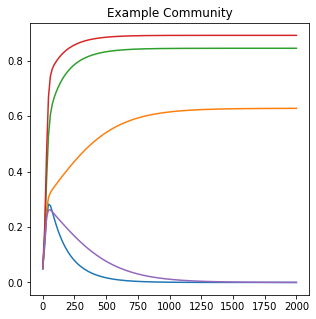

In [272]:
# Generate simulation paramters
params = random_parameters(n, mean, int_width, growth_mean, growth_var)
time_range, Gamma, sigma, mu, p_0  = params

# Integrate
sol = odeint(multi_species_model, p_0, time_range, args = (n,Gamma, sigma, mu, ))

# Plote solution
plt.figure(figsize = (5,5))
plt.title("Example Community")
plt.plot(time_range, sol)
plt.show()

Now we will simulate 9,500 individual growth curves in 1900 groups of 5 members communities, rolling different interaction matrices and growth rate terms for each one. We include some code to drop any growth curves which show unbounded growth due to numerical integration errors (if poor time step is chosen). 

In [276]:
n = 5

sim_lists = []
for i in trange(1900):
    
    # Roll new parameters
    params = random_parameters(n, mean, int_width, growth_mean, growth_var)
    time_range, Gamma, sigma, mu, p_0, = params

    # Integrate
    sol = odeint(multi_species_model, p_0, time_range, args = (n,Gamma, sigma, mu,))
    
    # Add valid growth curves to the growing list. 
    for i in range(sol.shape[1]):
        # Make sure we drop any integrals resulting from outside the [0,1.0] domain
        if np.isnan(sol[:,i]).any():
            pass
        elif sol[sol > 1.0].any():
            pass
        else:
            # Take the finite difference to estimate the derivative. 
            sim_lists.append(np.diff(sol[:,i]))

  0%|          | 0/1900 [00:00<?, ?it/s]

In [278]:
# Store the final growth curves in a numpy array. 
sols = np.array(sim_lists)
print(sols.shape)

(9500, 133)


Visualize the a random 100 curves:

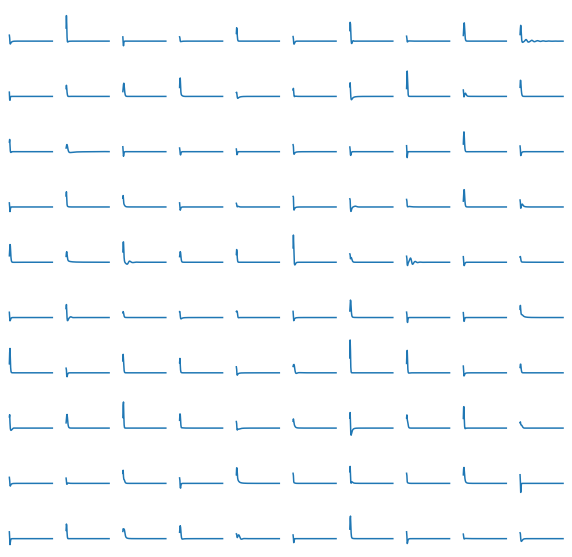

In [281]:
fig, axs = plt.subplots(10,10, figsize = (10,10), sharex = True, sharey = True)
axs = axs.flatten()

# Choose 100 curves at random and plot them
A = sols[np.random.randint(sols.shape[0],size = 100),:]
for i in range(100):
    axs[i].plot(A[i])
    axs[i].axis("off")
plt.show()

Optinally save the dataset:

In [285]:
np.savetxt("./saved_sims/ex_complex.csv", sols, delimiter=",")